In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(deaths_url, sep=',')
path_to_save = '../../figures/'
path_data = '../../data/'

In [2]:
def delay_cases(new_I_t, len_new_I_t, len_new_cases_obs , delay, delay_arr):
    """
    Delays the input new_I_t by delay and return and array with length len_new_cases_obs
    The initial delay of the output is set by delay_arr. 
    
    Take care that delay is smaller or equal than delay_arr, otherwise zeros are 
    returned, which could potentially lead to errors

    Also assure that len_new_I_t is larger then len(new_cases_obs)-delay, otherwise it 
    means that the simulated data is not long enough to be fitted to the data.
    """
    delay_mat = make_delay_matrix(n_rows=len_new_I_t, 
                                  n_columns=len_new_cases_obs, initial_delay=delay_arr)
    inferred_cases = interpolate(new_I_t, delay, delay_mat)
    return inferred_cases 

def make_delay_matrix(n_rows, n_columns, initial_delay=0):
    """
    Has in each entry the delay between the input with size n_rows and the output
    with size n_columns
    """
    size = max(n_rows, n_columns)
    mat = np.zeros((size, size))
    for i in range(size):
        diagonal = np.ones(size-i)*(initial_delay + i)
        mat += np.diag(diagonal, i)
    for i in range(1, size):
        diagonal = np.ones(size-i)*(initial_delay - i)
        mat += np.diag(diagonal, -i)
    return mat[:n_rows, :n_columns]

def interpolate(array, delay, delay_matrix):
    interp_matrix = tt.maximum(1-tt.abs_(delay_matrix - delay), 0)
    interpolation = tt.dot(array,interp_matrix)
    return interpolation

In [3]:
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time

date_data_begin = datetime.date(2020,6,8)
date_data_end = datetime.date(2020,7,13)
num_days_to_predict = 240


diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "US", 
                        date_formatted_begin:date_formatted_end])[0]
#cases_obs = np.concatenate([np.nan*np.ones(diff_data_sim), cases_obs])
print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = (date_data_end - date_begin_sim).days
date_today = date_data_end + datetime.timedelta(days=1)
# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.24), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(0.2), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_germany = 328e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_germany)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)
    
    # -------------------------------------------------------------------------- #
    # prediction, start with no changes in policy
    # -------------------------------------------------------------------------- #

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_germany)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_no_change]), 
                                     len_new_I_t=diff_data_sim + num_days_to_predict, 
                                     len_new_cases_obs=num_days_to_predict, 
                                     delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_no_change', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # social distancing, m reduced by about 50 percent
    # -------------------------------------------------------------------------- #
    #For all following predictions:
    length_transient = 30  # days


    # λ is decreased by 50%
    reduc_factor_mild = 0.1
    days_offset = 0  # start the decrease in spreading rate after this

    time_arr = np.arange(num_days_to_predict)

    # change in m along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_soc_dist= λ * (1 - λ_correction * reduc_factor_mild) 

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_soc_dist = SIR_model(λ=λ_t_soc_dist, μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, 
                        N=N_germany)
    S_soc_dist, I_soc_dist, new_I_soc_dist = forecast_soc_dist
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_soc_dist]), 
                                    len_new_I_t=diff_data_sim + num_days_to_predict, 
                                    len_new_cases_obs=num_days_to_predict, 
                                    delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_soc_dist', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # isolation, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.2
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)  
    pm.Deterministic('new_I_isol', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # isolation 5 days later, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol_later= λ * (1 - λ_correction * reduc_factor_strong) 

    S_begin = S_past[-1]
    I_S_beginbegin = I_past[-1]
    forecast_isol_later = SIR_model(λ=λ_t_isol_later, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_isol_later, I_isol_later, new_I_isol_later = forecast_isol_later

    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)  
    pm.Deterministic('new_I_isol_later', new_I_isol_later)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol_later]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol_later', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # isolation 5 days earlier, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    length_transient = 7

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset, num_days_to_predict)

    # change in λ along time

    λ_t_earlier  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset]
    I_begin = I_past[-1 + days_offset]
    forecast_earlier = SIR_model(λ=λ_t_earlier, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_earlier, I_earlier, new_I_earlier = forecast_earlier

    pm.Deterministic('S_earlier', S_earlier)
    pm.Deterministic('I_earlier', I_earlier)  
    pm.Deterministic('new_I_earlier', new_I_earlier)
    pm.Deterministic('λ_t_earlier', λ_t_earlier)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset], new_I_earlier]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    
    pm.Deterministic('new_cases_earlier', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # long transient scenario
    # -------------------------------------------------------------------------- #

    length_transient = 14

    # λ is decreased by 65%
    reduc_factor = 0.6
    days_offset = -3.5  # start the decrease in spreading rate after this
    days_offset_sim = -4

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset_sim, num_days_to_predict)

    # change in λ along time

    λ_t_long_trans  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset_sim]
    I_begin = I_past[-1 + days_offset_sim]
    forecast_long_trans = SIR_model(λ=λ_t_long_trans, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_long_trans, I_long_trans, new_I_long_trans = forecast_long_trans

    pm.Deterministic('S_long_trans', S_long_trans)
    pm.Deterministic('I_long_trans', I_long_trans)  
    pm.Deterministic('new_I_long_trans', new_I_long_trans)
    pm.Deterministic('λ_t_long_trans', λ_t_long_trans)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset_sim], new_I_long_trans]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_long_trans', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # immediate transient scenario
    # -------------------------------------------------------------------------- #

    # λ is decreased by 65%
    reduc_factor_strong = 0.6
    days_offset = 3.5 # start the decrease in spreading rate after this
    length_transient = 0.5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_immedi', S_isol)
    pm.Deterministic('I_immedi', I_isol)  
    pm.Deterministic('new_immedi', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                    len_new_I_t=diff_data_sim + num_days_to_predict, 
                                    len_new_cases_obs=num_days_to_predict, 
                                    delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_immedi', new_cases_inferred)
    
    # -------------------------------------------------------------------------- #
    # middle transient scenario
    # -------------------------------------------------------------------------- #

    # λ is decreased by 65%
    reduc_factor_strong = 0.6
    days_offset = 0 # start the decrease in spreading rate after this
    length_transient = 7

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_middle_trans', S_isol)
    pm.Deterministic('I_middle_trans', I_isol)  
    pm.Deterministic('new_middle_trans', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                    len_new_I_t=diff_data_sim + num_days_to_predict, 
                                    len_new_cases_obs=num_days_to_predict, 
                                    delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_middle_trans', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    
    time_beg = time.time()
    trace = pm.sample(draws=500, tune=500, chains=4)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

Cases yesterday (2020-07-13): 3364157 and day before yesterday: 3304942


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ_obs, delay, μ, λ, I_begin]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 1175 seconds.
The acceptance probability does not match the target. It is 0.8875754669847151, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Model run in 1222.94 s


ValueError: x and y must have same first dimension, but have shapes (36,) and (100,)

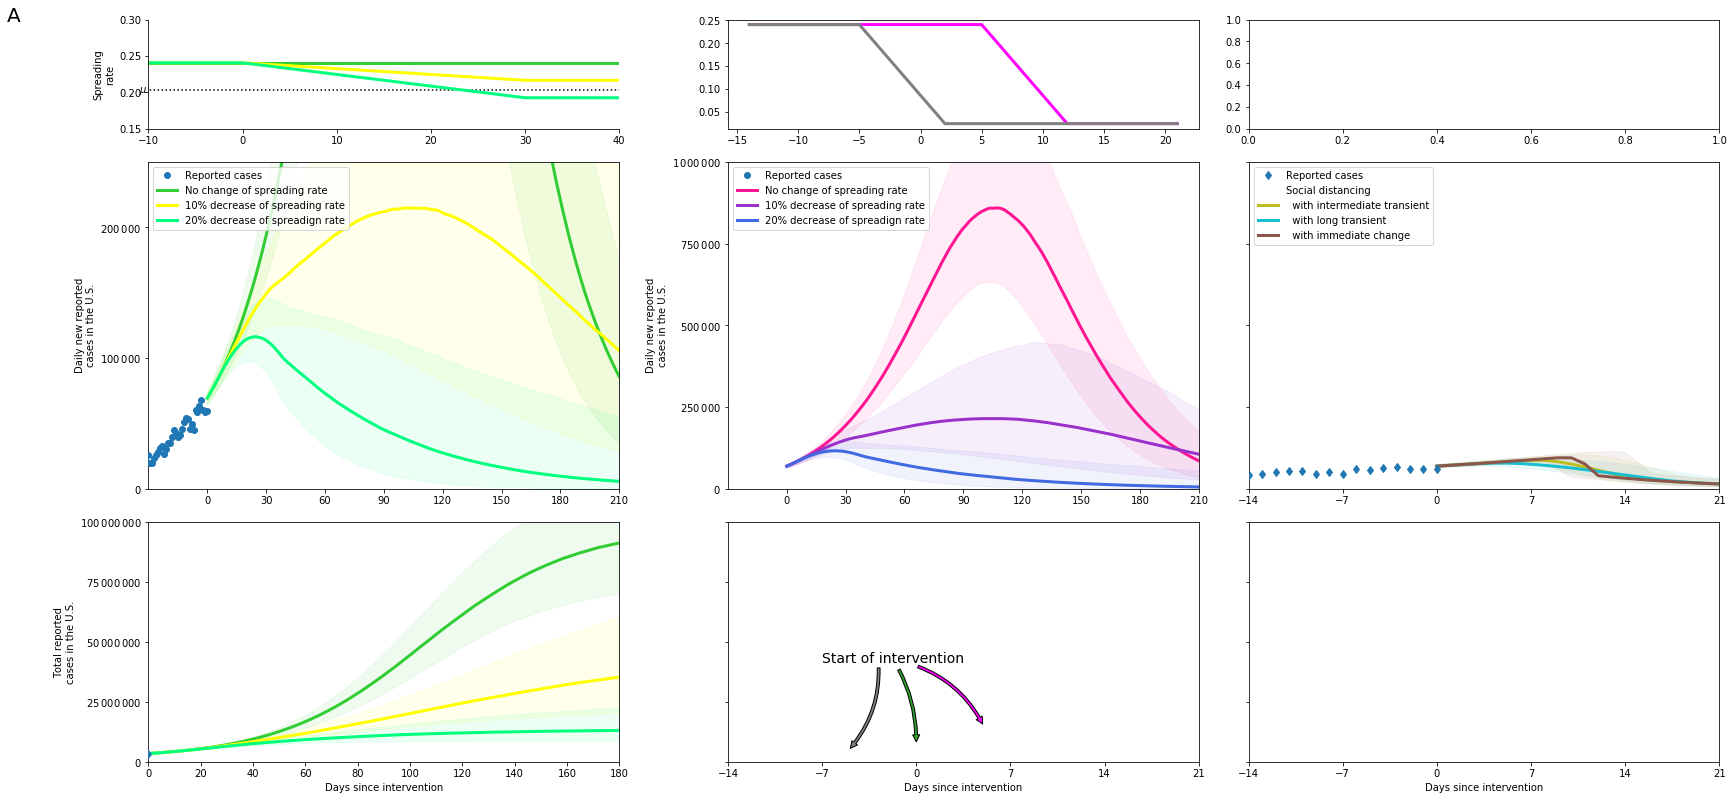

In [6]:
legends_lang = {
    "english": [
        # bottom left
        "Reported cases",
        [
            "No change of spreading rate",
            "10% decrease of spreading rate",
            "20% decrease of spreadign rate",
            "Strong social distancing since 5 days ago",
        ],
        "Days since intervention",
        "Total reported\ncases in the U.S.",
        "",
        # bottom right
        "Reported cases",['Strong social distancing:',
                           '  starting at day 0', 
                           '  starting at day 5',
                           "  starting at day -5"],
        'Days since intervention',
        "Daily new reported\ncases in the U.S.",
        'Start of intervention',
        "Spreading\nrate",
        ['Social distancing',
         '  with intermediate transient',
         '  with long transient', 
         '  with immediate change'],
    ],
}

obs_cases_labels = ['new_cases_no_change', 'new_cases_soc_dist', 
                    'new_cases_isol', 'new_cases_isol_later','new_cases_earlier', 
                    'new_cases_middle_trans', 'new_cases_long_trans','new_cases_immedi']


cases_obs_to_plot = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'US', date_formatted_begin:date_formatted_end])[0]
cases_obs_to_plot_future = np.array(confirmed_cases.loc[confirmed_cases['Country/Region'] == 'US', date_formatted_end:])[0]


def return_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = np.cumsum(trace[label], axis=1) + \
        np.sum(trace.new_cases_past, axis=1)[:, None] + cases_obs[0]
    obs_cases_future[label] = obs_cases_future[label].T
  return obs_cases_future

def return_new_obs_cases_future(trace):
  obs_cases_future = dict()
  for label in obs_cases_labels:
    obs_cases_future[label] = trace[label]
    obs_cases_future[label] = obs_cases_future[label].T
  return obs_cases_future

obs_cases_labels_local = obs_cases_labels[:]
obs_cases_labels_local.pop(3)
ms = 6

for lang, legends_list in legends_lang.items():
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=[24, 11],gridspec_kw={'width_ratios': [1, 1,1],
                                                                           'height_ratios': [1,3,2.2]},
                            constrained_layout=True)
    dict_obsc_cases = return_obs_cases_future(trace)
    dict_new_obs_cases = return_new_obs_cases_future(trace)
    
    
    #middle left
    
    colors = ["limeGreen", "yellow", "SpringGreen"]
    ax = axes[1, 0]

    time = np.arange(-len(cases_obs_to_plot)+2, 1)
    ax.plot(time, np.diff(cases_obs_to_plot), "o",ms=ms, label=legends_list[0], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)

    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_new_obs_cases[label]
        # cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)

        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-30, 210)
    ax.set_ylim(0, 250_000)
    ax.set_yscale("linear")
    ax.set_ylabel(legends_list[8])
    # ax.locator_params(axis='y', nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([0, 30, 60, 90, 120, 150, 180,210])
    ax.locator_params(nbins=4, axis="y")
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    #ax.text(-0.3, 0.98, "B", transform=ax.transAxes, size=20)

    #ax.annotate(
        #legends_list[4],
       # xy=(0.0, 3_000),
       # xycoords="data",
       # xytext=(0.35, 0.3),
       # textcoords="axes fraction",
       # size=14,
       # va="bottom",
       # ha="center",
      #  arrowprops=dict(
      #      arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc="black"
     #   ),
   # )
    
    # bottom left
    colors = ["LimeGreen", "yellow", "SpringGreen"]

    ax = axes[2, 0]

    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, "d",ms=ms, label=legends_list[0], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)

    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_obsc_cases[label]
        # cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)

        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(0, 180)
    ax.set_ylim(0, 1000_00000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[2])
    ax.set_ylabel(legends_list[3])
    # ax.locator_params(axis='y', nbins=4)
    #ax.legend(loc="upper left")
    #ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.locator_params(nbins=4, axis="y")
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    #ax.text(-0.3, 0.98, "B", transform=ax.transAxes, size=20)

    ax.annotate(
        legends_list[4],
        xy=(0.0, 15_000),
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=14,
        va="bottom",
        ha="center",
    
    )

    # middle middle
    ax = axes[1, 1]
    
    colors = ["deeppink", "darkorchid", "royalblue"]
  

    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, "o",ms=ms, label=legends_list[0], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)

    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_obsc_cases[label]
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)

    for label, color, legend in zip(obs_cases_labels_local, colors, legends_list[1]):
        time = np.arange(0, num_days_to_predict)
        cases = dict_new_obs_cases[label]
        # cases = np.concatenate([np.ones((1,cases.shape[1]))*cases_obs[-1], cases], axis=0)

        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-30, 210)
    ax.set_ylim(0, 1000_000)
    ax.set_yscale("linear")
    ax.set_ylabel(legends_list[8])
    # ax.locator_params(axis='y', nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([0, 30, 60, 90, 120, 150, 180,210])
    ax.locator_params(nbins=4, axis="y")
    func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    #ax.text(-0.1, 0.98, "D", transform=ax.transAxes, size=20)
    '''
    ax.annotate(
        legends_list[9],
        xy=(0.0, 1_300),
        xycoords="data",
        xytext=(0.35, 0.25),
        textcoords="axes fraction",
        size=14,
        va="bottom",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.15", fc=colors[0]
        ),
    )
    ax.annotate(
        "",
        xy=(5.0, 5_000),
        xycoords="data",
        xytext=(0.4, 0.25),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[1]
        ),
    )

    ax.annotate(
        "",
        xy=(-5.0, 1_000),
        xycoords="data",
        xytext=(0.32, 0.25),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[2]
        ),
    )
    '''

    # bottom middle
    ax = axes[2, 1]
    colors = ["tab:green", "fuchsia", 'gray']
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, "d",ms=ms, label=legends_list[5], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)

    dict_obsc_cases = return_obs_cases_future(trace)
    ax.plot([], [], alpha=0, label=legends_list[6][0])
    for label, color, legend in zip(obs_cases_labels[2:], colors, legends_list[6][1:]):
        time = np.arange(num_days_to_predict)
        cases = dict_obsc_cases[label]
        #cases = np.concatenate([np.ones((1, cases.shape[1])) * cases_obs[-1], cases], axis=0)
        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(0, 200_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[7])
    #ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    #ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.tick_params(labelleft=False)    

    #ax.text(-0.1, 0.98, "D", transform=ax.transAxes, size=20)

    ax.annotate(
        legends_list[9],
        xy=(0.0, 15_000),
        xycoords="data",
        xytext=(0.35, 0.4),
        textcoords="axes fraction",
        size=14,
        va="bottom",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.15", fc=colors[0]
        ),
    )
    ax.annotate(
        "",
        xy=(5.0, 30_000),
        xycoords="data",
        xytext=(0.4, 0.4),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[1]
        ),
    )

    ax.annotate(
        "",
        xy=(-5.0, 10_000),
        xycoords="data",
        xytext=(0.32, 0.4),
        textcoords="axes fraction",
        size=14,
        va="center",
        ha="center",
        arrowprops=dict(
            arrowstyle="simple", connectionstyle="arc3,rad=-0.2", fc=colors[2]
        ),
    )
    
    # middle right
    ax = axes[1, 2]
    colors = ["tab:olive", "tab:cyan", 'tab:brown']
    time = np.arange(-len(cases_obs_to_plot)+2, 1)
    ax.plot(time, np.diff(cases_obs_to_plot), "d", ms=ms, label=legends_list[5], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)

    ax.plot([], [], alpha=0, label=legends_list[11][0])
    for label, color, legend in zip([obs_cases_labels[-3], obs_cases_labels[-2], obs_cases_labels[-1]], 
                                    colors, legends_list[11][1:]):
        time = np.arange(num_days_to_predict)
        cases = dict_new_obs_cases[label]
        #cases = np.concatenate([np.ones((1, cases.shape[1])) * cases_obs[-1], cases], axis=0)
        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(0, 1000_000)
    ax.set_yscale("linear")
    #ax.set_xlabel(legends_list[7])
    #ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.tick_params(labelleft=False)    

    #ax.text(-0.1, 0.98, "F", transform=ax.transAxes, size=20)

    # bottom right
    ax = axes[2, 2]
    time = np.arange(-len(cases_obs_to_plot)+1, 1)
    ax.plot(time, cases_obs_to_plot, "d",ms=ms, label=legends_list[5], linewidth=3, color='tab:blue', 
                zorder=5)
    time = np.arange(0, len(cases_obs_to_plot_future))
    #ax.plot(time, cases_obs_to_plot_future, '.', markersize=5, color='tab:blue', 
    #        zorder=5)
    time = np.arange(-len(cases_obs) + 1, 1)

    dict_obsc_cases = return_obs_cases_future(trace)
    for label, color, legend in zip([obs_cases_labels[-3], obs_cases_labels[-2], obs_cases_labels[-1]], 
                                    colors, legends_list[11]):
        time = np.arange(num_days_to_predict)
        cases = dict_obsc_cases[label]
        #cases = np.concatenate([np.ones((1, cases.shape[1])) * cases_obs[-1], cases], axis=0)
        median = np.median(cases, axis=-1)
        percentiles = (
            np.percentile(cases, q=2.5, axis=-1),
            np.percentile(cases, q=97.5, axis=-1),
        )
        ax.plot(time, median, color, linewidth=3, label=legend)
        ax.fill_between(time, percentiles[0], percentiles[1], alpha=0.08, color=color)

    ax.set_xlim(-14, 21)
    ax.set_ylim(0, 200_000)
    ax.set_yscale("linear")
    ax.set_xlabel(legends_list[7])
    #ax.set_ylabel(legends_list[8])
    ax.locator_params(axis="y", nbins=4)
    #ax.legend(loc="upper left")
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #func_format = lambda num, _: "${:,.0f}$".format(num).replace(",", "\,")
    #ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(func_format))
    ax.tick_params(labelleft=False)    

    #ax.text(-0.1, 0.98, "F", transform=ax.transAxes, size=20)

    # top left
    ax = axes[0, 0]

    m = np.median(trace.λ)
    decrease_in = 30  # days
    time = np.arange(-40, 60)
    m_correction = np.clip(time / decrease_in, 0, 1)
    reduction_fact_strong = 0.2
    reduction_fact_mild = 0.1

    ax.plot(time, np.ones_like(time)*m, linewidth=3, color="LimeGreen")
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_mild)*m,
        linewidth=3,
        color="yellow" )
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_strong)*m,
        linewidth=3,
        color="SpringGreen" )
    ax.hlines(np.median(trace.μ),-50,50, linestyles=':',label='critical point')
    #ax.legend()

    ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
  #  ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.set_ylim(0.15, 0.3)
   # ax.set_yticks([0, 0.2, 0.4])
    ax.set_xlim(-10, 40)
    #ax.set_aspect(14, adjustable="box")
    ax.text(-0.3, 0.98, "A", transform=ax.transAxes, size=20)
    ax.text(-11, 0.2, "$\mu$", transform=ax.transData, size=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    # top middle
    ax = axes[0, 1]

    m = np.median(trace.λ)
    length_transient = 7  # days
    time = np.arange(-14, 22)
    
    reduc_factor_mild = 0.9
    days_offset_mild = -5  # start the decrease in spreading rate after this
    reduc_factor_strong = 0.9
    days_offset_strong = 5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_t1  = np.clip((time-days_offset_mild) / length_transient, 0, 1)*\
                      (m*(1-reduc_factor_mild) - m)+m
    λ_t2  = np.clip((time-days_offset_strong) / length_transient, 0, 1)*\
                      (m*(1-reduc_factor_strong) - m)+m

    #ax.plot(time, np.ones_like(time), linewidth=3, color="tab:red", label="no change")
    
    ax.plot(
        time,
        (λ_t2),
        linewidth=3,
        color="fuchsia",
    )
    ax.plot(
        time,
        (λ_t1),
        linewidth=3,
        color="gray",
    )
    ax.plot(
        time,
        (1 - m_correction * reduction_fact_strong)*m,
        linewidth=3,
        color="tab:green",
    )
    ax.hlines(np.median(trace.μ),-50,50, linestyles=':',label='critical point')
    #ax.legend()

    #ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    #ax.set_yticks([0, 0.5, 1.0])
    ax.set_yticks([0, 0.2, 0.4])
    ax.tick_params(labelleft=False)    
    ax.set_ylim(0, 0.5)
    ax.set_xlim(-14, 21)
    #ax.set_aspect(14, adjustable="box")
    ax.text(-0.1, 0.98, "B", transform=ax.transAxes, size=20)
    ax.text(-11, 0.2, "$\mu$", transform=ax.transData, size=10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # top right
    ax = axes[0, 2]

    m = np.median(trace.λ)
    length_transient1 = 14  # days
    length_transient2 = 0.5
    time = np.arange(-14, 22)
    reduc_factor_mild = 0.6
    days_offset_mild = -3.5  # start the decrease in spreading rate after this

    reduc_factor_strong = 0.6
    days_offset_strong = 3.5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_t1  = np.clip((time-days_offset_mild) / length_transient1, 0, 1)*\
                      (m*(1-reduc_factor_mild) - m)+m
    λ_t2  = np.clip((time-days_offset_strong) / length_transient2, 0, 1)*\
                      (m*(1-reduc_factor_strong) - m)+m

    #ax.plot(time, np.ones_like(time), linewidth=3, color="tab:red", label="no change")
    
    ax.plot(
        time,
        λ_t2,
        linewidth=3,
        color="tab:brown",
    )
    ax.plot(
        time,
        (λ_t1),
        linewidth=3,
        color="tab:cyan",
    )
    ax.plot(
        time,
        (1 - m_correction *reduc_factor_strong)*m,
        linewidth=3,
        color="tab:olive",
    )

    ax.hlines(np.median(trace.μ),-50,50, linestyles=':',label='critical point')
    #ax.legend()

    #ax.set_ylabel(legends_list[10])
    # ax.set_xlabel("days from now")
    # ax.legend(loc='lower left')
    ax.set_xticks([-14, -7, 0, 7, 14, 21])
    ax.set_yticks([0, 0.2, 0.4])
    ax.tick_params(labelleft=False)    
    ax.set_ylim(0, 0.5)
    ax.set_xlim(-14, 21)
    #ax.set_aspect(14, adjustable="box")
    ax.text(-0.1, 0.98, "C", transform=ax.transAxes, size=20)
    ax.text(-11, 0.2, "$\mu$", transform=ax.transData, size=10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # wrapping up
    #fig.subplots_adjust(hspace=-0.50)
    #fig.subplots_adjust(wspace=-.1)
    #fig.tight_layout()
    fig.savefig(
        path_to_save + "Fig_2.png".format(lang), dpi=300
    )

print('effective m: {:.3f} +- {:.3f}'.format(1+np.median(trace.λ - trace.μ), np.std(trace.λ - trace.μ)))
print('λ: {:.3f} [{:.3f}, {:.3f}]'.format(np.median(trace.λ), *np.percentile(trace.λ, q=(2.5, 97.5))))

In [7]:
a=return_obs_cases_future(trace)
b=return_new_obs_cases_future(trace)

In [8]:
d30d=np.median(a['new_cases_soc_dist'][30])
d60d=np.median(a['new_cases_soc_dist'][60])
d90d=np.median(a['new_cases_soc_dist'][90])
d120d=np.median(a['new_cases_soc_dist'][120])
d150d=np.median(a['new_cases_soc_dist'][150])
d180d=np.median(a['new_cases_soc_dist'][180])
d210d=np.median(a['new_cases_soc_dist'][210])

print(d30d,d60d,d90d,d120d,d150d,d180d,d210d)

6814521.124391532 11902020.498219784 17971750.93587754 24472402.112421356 30389124.80604528 35303000.525538646 39199275.03970118


In [9]:
d30d=np.median(a['new_cases_isol'][30])
d60d=np.median(a['new_cases_isol'][60])
d90d=np.median(a['new_cases_isol'][90])
d120d=np.median(a['new_cases_isol'][120])
d150d=np.median(a['new_cases_isol'][150])
d180d=np.median(a['new_cases_isol'][180])
d210d=np.median(a['new_cases_isol'][210])
d240d=np.median(a['new_cases_isol'][140])
print(d30d,d60d,d90d,d120d,d150d,d180d,d210d,d240d)

6513253.876368746 9245983.092102706 11008954.091933109 12065592.085843004 12700771.02320921 13088010.08090915 13333239.290408479 12524032.44021909


In [10]:
np.median(b['new_cases_soc_dist'][90])

211877.12669005356

In [11]:
np.median(b['new_cases_soc_dist'][100])

214533.07992252515

In [12]:
np.median(b['new_cases_soc_dist'][105])

214615.15303590757

In [13]:
np.median(b['new_cases_soc_dist'][110
                                 ])

214480.56631789746

In [14]:
np.median(b['new_cases_isol'][30
                                 ])

113534.62166140473

In [15]:
np.median(b['new_cases_isol'][20
                                 ])

114376.86783039197

In [16]:
np.median(b['new_cases_isol'][40
                                 ])

97981.16276750088

In [17]:
np.median(b['new_cases_isol'][35
                                 ])

106624.28983176438